# Проект по минимизации энергозатрат для МК  «Так закаляем сталь»

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.

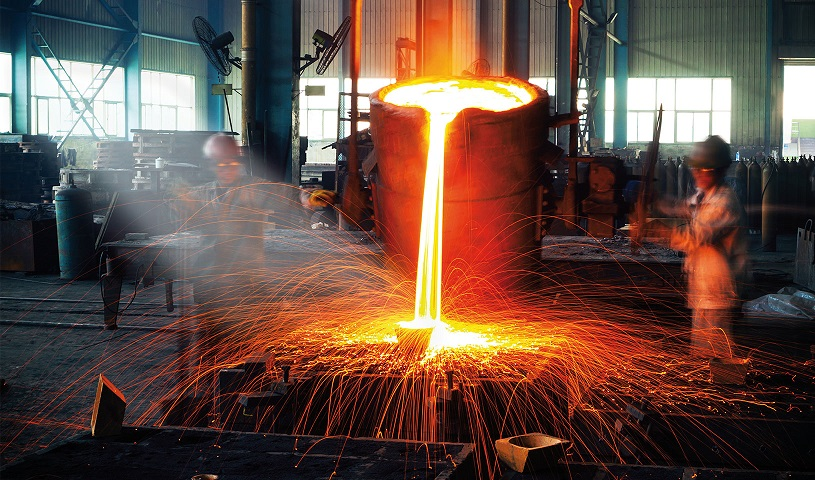

***Описание технологии комплексной внепечной обработки стали в литейном производстве***

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

## Цель проекта

  **Цель** -  построить модель, которая предскажет температуру стали.
  
  **Объект моделирования** -  одна партия (один ковш, процесс варки).
  
  **Задачи модели машинного обучения** - сократить расходы на электроэнергию, уменьшить перегрев оборудования и снизить затраты на ремонт и обслуживание. Метрика оценки качества построенной модели - МАЕ (по требованию заказчика) не должна превышать 6,8 единиц.
 

## План работы
- Проведем исследовательский анализ данных 
- Осуществим предобработку данных 
- Подготовим данные для машинного обучения, сгенерируем новые признаки для МО  
- Построим модель для решения задачи регрессии
- Составим отчет с рекомендациями для заказчика

## Импорт библиотек

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor
from lightgbm import plot_importance

RANDOM_STATE = 30723

import warnings
warnings.filterwarnings('ignore') 

## Исследовательский анализ

In [3]:
# создадим список датафреймов для обращения к ним по номеру
list_df = [arc_new, bulk_new, bulk_time_new, gas_new, temp_new, wire_new, wire_time_new]
len(list_df)

7

In [4]:
# создадим функцию получения полной информации об имеющихся в нашем распоряжении датафреймах
def get_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe())

### Датафрейм с данными об электродах

In [5]:
# применим функцию получения информации к данным об электродах
get_info(list_df[0])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
13939,3024,2019-08-30 06:17:48,2019-08-30 06:19:10,0.461309,0.331605
10359,2253,2019-08-01 15:04:01,2019-08-01 15:08:26,0.395131,0.268022
7285,1581,2019-07-01 21:20:46,2019-07-01 21:24:47,0.645462,0.484603
10434,2267,2019-08-02 00:52:36,2019-08-02 00:57:53,0.512694,0.425725
4344,933,2019-06-08 16:10:35,2019-06-08 16:12:52,0.317041,0.219271


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


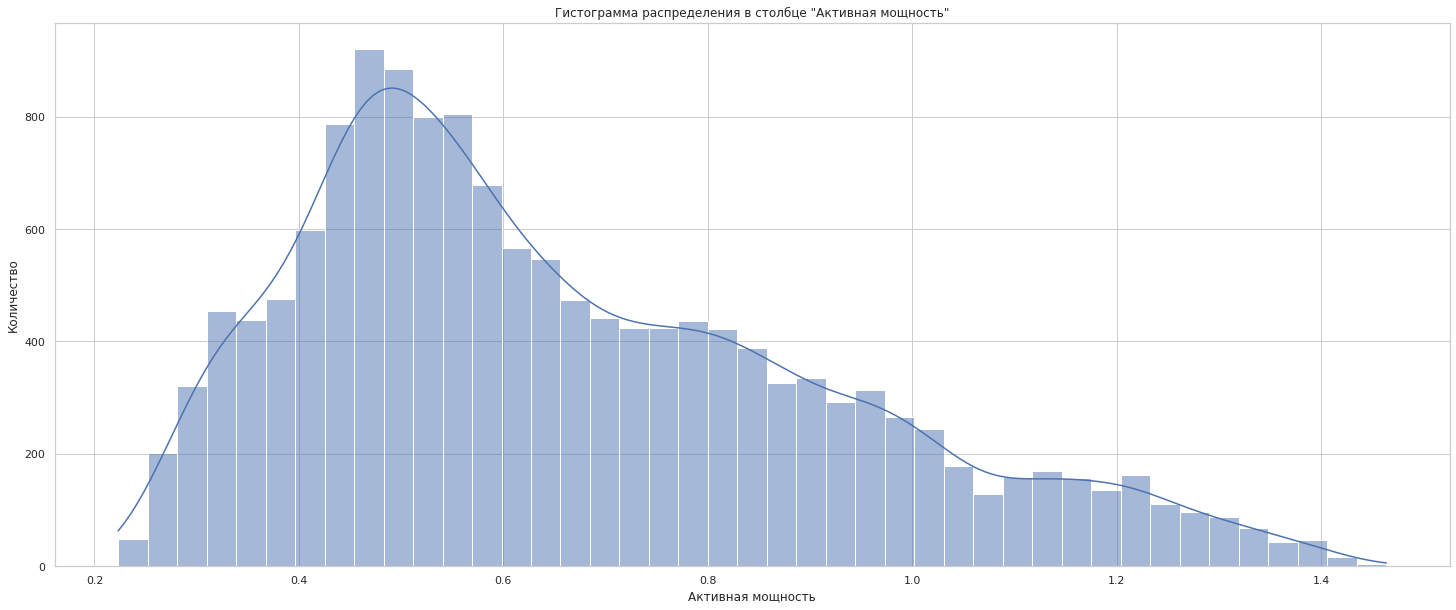

In [6]:
#построим гистограммы столбцов с численными значениями
sns.set(rc={"figure.figsize": (25, 10)})
sns.set_style('whitegrid')
ahf = sns.histplot(data=arc_new, x='Активная мощность', kde=True)
ahf.set_ylabel('ватт')
ahf.set_title('Гистограмма распределения в столбце "Активная мощность"');
#arc_new['Активная мощность'].plot (kind='hist', xlim=(0,2), title=, bins=100, figsize=(15,5));

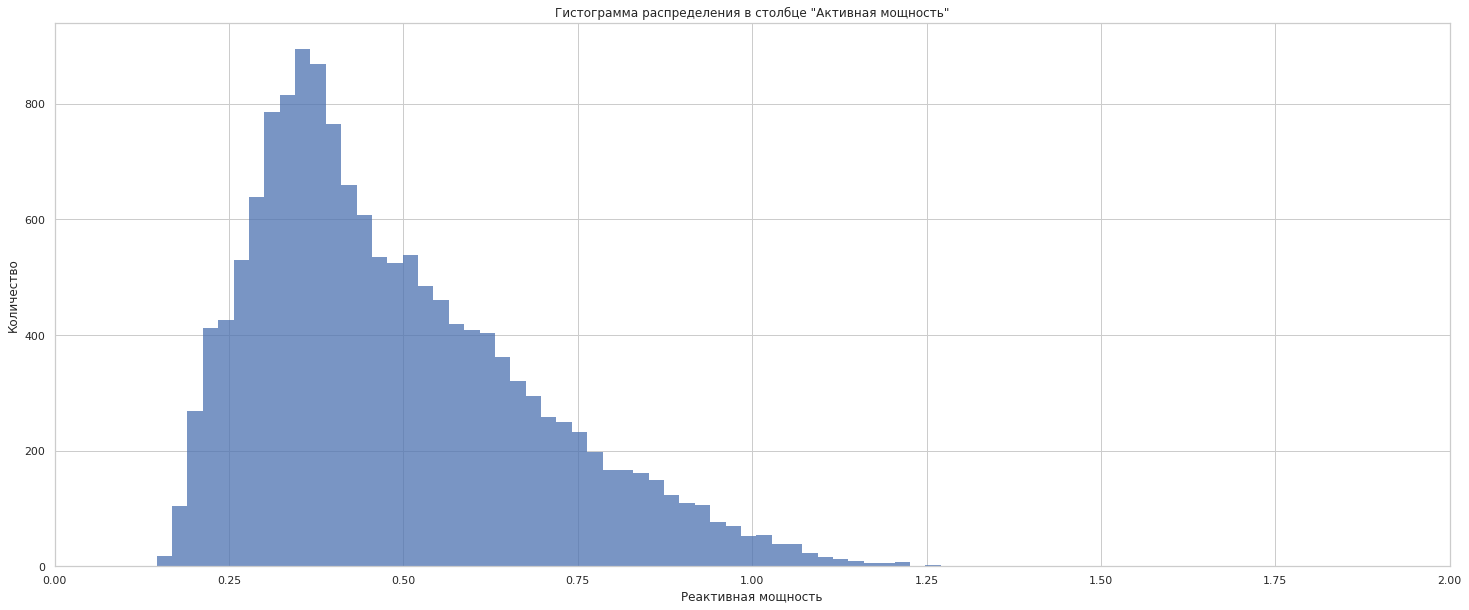

In [23]:
#построим гистограмму arc_new['Реактивная мощность'].plot 
#(kind='hist', , title='Реактивная мощность', bins=100, figsize=(15,5));
sns.set(rc={"figure.figsize": (25, 10)})
sns.set_style('whitegrid')
ahf = sns.histplot(data=arc_new, x='Реактивная мощность')
ahf.set_ylabel('вар')
ahf.set_title('Гистограмма распределения в столбце "Реактивная мощность"')
ahf.set_xlim(0,2);

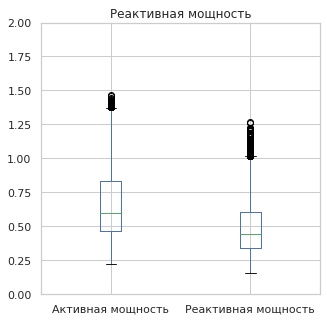

In [8]:
# для детализации распределения значений построим "ящик с усами" для столбцов активная и реактивная мощность
arc_new[['Активная мощность','Реактивная мощность']].plot(kind='box',ylim=(0,2), figsize=(5, 5))
plt.title('Реактивная мощность');

In [9]:
# уточним количество уникальных значений столбца 'key' (номер партии)
arc_new.key.nunique()

3214

#### Вывод по результатам исследоваия данных об электродах
В датафрейме данных об электродах содержится около 15 тыс. наблюдений о 3214 партиях. То есть зафиксировано по несколько замеров в каждой партии. Это информация о времени замера и количественном показателе активной и реактивной мощности электродов. Данные об активной мощности имеют нормальное распределение, колеблются в районе единицы, аномалий не выявлено. В столбце с реактивной мощностью обнаружены аномалии со значением в районе -700. По информации от заказчика, отрицательных значений в данных замерах быть не может (возможно присутствует ошибка в занесении данных). Пропусков в таблице нет.

### Датафрейм с данными о подаче сыпучих материалов (объём)

In [10]:
# применим функцию получения информации к данным о подаче сыпучих материалов
get_info(list_df[1])

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2912,3019,NaN,NaN,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.0,NaN,102.0,106.0
2423,2515,118.0,NaN,232.0,NaN,NaN,206.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,452.0,108.0
1776,1838,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,512.0,NaN,200.0,102.0
1801,1863,NaN,NaN,181.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,199.0,204.0
1235,1285,54.0,NaN,76.0,NaN,NaN,NaN,NaN,NaN,NaN,49.0,NaN,562.0,NaN,259.0,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


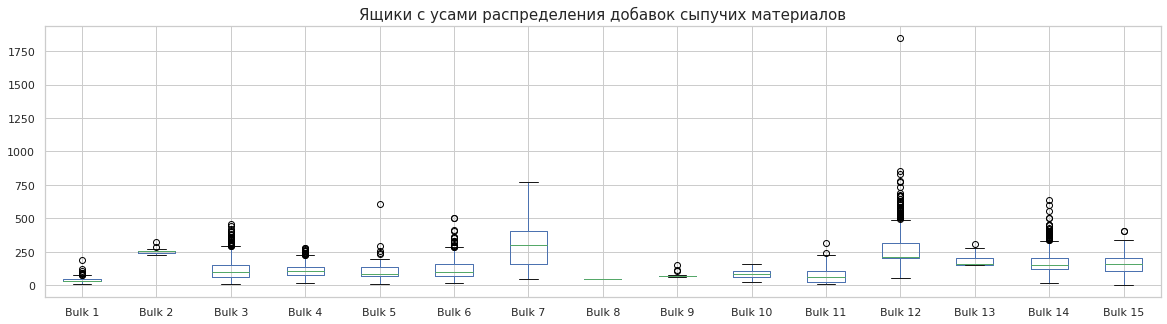

In [24]:
bulk_new[['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5','Bulk 6','Bulk 7',
          'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11','Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']].plot(kind='box',\
                                                                                           figsize=(20, 5))
plt.title('Ящики с усами распределения добавок сыпучих материалов', fontsize=15);

#### Вывод по результатам исследоваия данных об объёме подаче сыпучих материалов
В этом датафрейме содержится 3129 наблюдений, что почти равно количеству партий.Подача сыпучих материалов является частью производствнного цикла и судя по таблице, этих циклов 15. В каждом цикле для каждой партии было добавлено определенное количество сыпучих материалов. Во многих строках наблюдаются пропуски - это говорит об отсутствии подачи сыпучего материала в данном цикле данной партии. Аномалий в этой таблице нет, слишком большие или малые значения являются частью нормы и будут также полезны для моделирования.

<div class="alert alert-success">
<h2> Комментарий ревьюера  <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Хорошо, что есть промежуточный вывод)

### Датафрейм с данными о подаче сыпучих материалов (время)

In [12]:
get_info(list_df[2])

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
166,180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-10 13:14:34,NaN,2019-05-10 13:11:15,2019-05-10 13:07:55
1996,2067,NaN,NaN,NaN,2019-07-25 21:42:19,2019-07-25 21:39:04,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-25 21:30:09,NaN,2019-07-25 21:26:35,2019-07-25 21:23:16
1231,1281,NaN,NaN,2019-06-20 19:28:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2706,2807,NaN,NaN,NaN,2019-08-22 03:38:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-22 03:43:03,NaN,2019-08-22 03:38:19,2019-08-22 03:32:44
35,36,NaN,NaN,NaN,2019-05-04 16:20:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-04 16:15:11,NaN,2019-05-04 16:10:35,2019-05-04 16:02:58


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


#### Вывод по результатам исследоваия данных о времени подачи сыпучих материалов
В этом датафрейме также содержится 3129 наблюдений - это время подачи сыпучих материалов, используется для проверки корректности данных и в моделировании использовано не будет.

### Датафрейм с данными о продувке сплава газом

In [13]:
get_info(list_df[3])

,key,Газ 1
132,133,11.424162
1563,1566,3.708308
1626,1629,8.958952
2585,2588,9.033905
594,597,7.584491


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


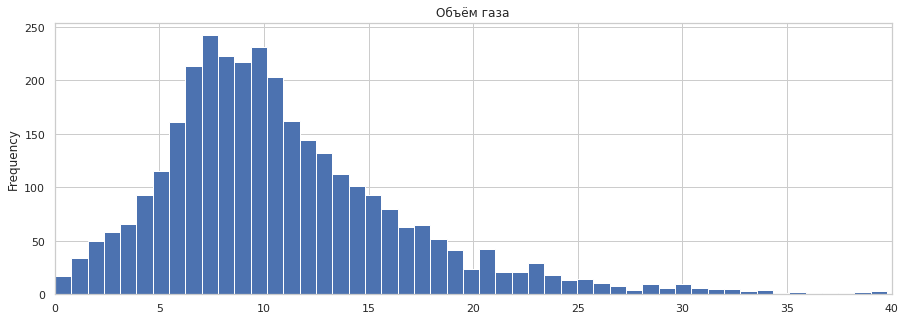

In [31]:
#построим гистограммы столбцов с численными значениями
gas_new['Газ 1'].plot (kind='hist', xlim=(0,40), title='Объём газа',  bins=100, figsize=(15,5));

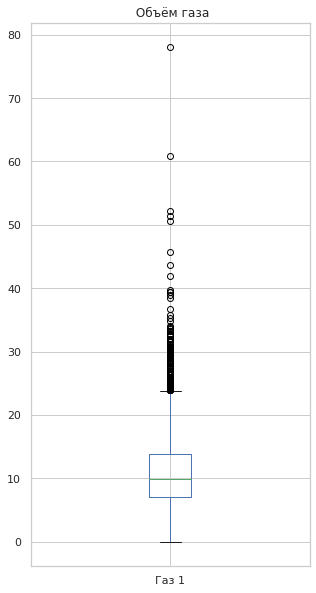

In [15]:
# для детализации распределения значений построим "ящик с усами" 
gas_new['Газ 1'].plot(kind='box', figsize=(5, 10))
plt.title(' Объём газа');

#### Вывод по результатам исследоваия данных о продувке сплава газом
В этом датафрейме содержится 3239 строк - это объём газа, используемого при продувке сплава  в каждой партии. Наблюдений больше чем партий, больше чем количество партий, возможно есть дубликаты. Пропусков нет.Аномалии определить сложно, скорее всего, показатели выше среднего являются частью бизнес-процесса.

### Датафрейм с данными о результатах измерения температуры

In [16]:
get_info(list_df[4])

,key,Время замера,Температура
5805,1032,2019-06-12 07:06:24,1577.0
9022,1613,2019-07-02 22:08:40,1573.0
8217,1470,2019-06-27 20:53:26,1600.0
3192,573,2019-05-25 06:11:40,1587.0
9663,1722,2019-07-06 13:26:51,1595.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


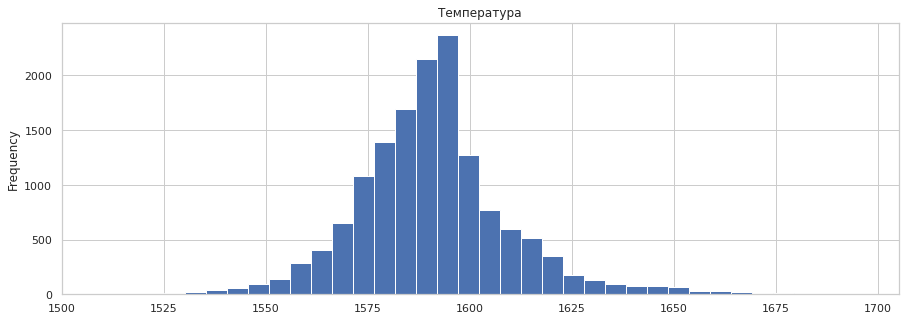

In [17]:
#построим гистограммы столбцов с численными значениями
temp_new['Температура'].plot (kind='hist', xlim=(1500,1705), title='Температура', bins=100, figsize=(15,5));

#### Вывод по результатам исследоваия данных о температуре
Датафрейм "temp_new" содержит 18092 замера температуры - по несколько раз в каждой партии. Пропусков нет. Выбросы присутствуют, так как температура плавления не может быть ниже 1500 градусов. В этой таблице содержится наш таргет - это  последняя по времени температура плавления в каждой партии. 

### Датафрейм с данными  о проволочных материалах (объём)

In [18]:
get_info(list_df[5])

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
588,624,145.173599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2707,2853,67.005119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1922,2017,111.209274,13.08944,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1084,1151,133.192795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2881,3034,113.043839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


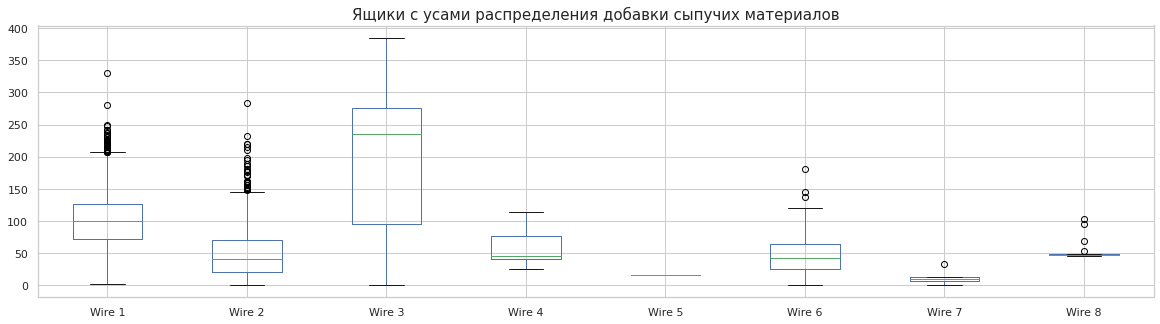

In [26]:
wire_new[['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5','Wire 6','Wire 7','Wire 8']].plot(kind='box',\
                                                                                           figsize=(20, 5))
plt.title('Ящики с усами распределения добавок проволочных материалов', fontsize=15);

#### Вывод  по результатам исследоваия данных об объёме подачи проволочных материалов
В этом датафрейме - 3081 наблюдение, что немного меньше количества партий. Подача проволочных материалов является частью производствнного цикла и судя по таблице, этих циклов может быть от 1 до 9. В каждом цикле для каждой партии было добавлено определенное количество материалов. Во многих строках наблюдаются пропуски - это говорит об отсутствии подачи проволочного материала в данном цикле данной партии. Аномалий в этой таблице нет, кроме столбца "Wire 5" с единственным замером, удалим его непосредственно перед МО. Слишком большие или малые значения являются частью нормы и будут также полезны для моделирования.

### Датафрейм с данными  о проволочных материалах (время)

In [ ]:
get_info(list_df[6])

#### Вывод по результатам исследоваия данных о времени подачи проволочных материалов
Датафрейм содержится 3081 строку - это время подачи проволочных материалов, используется для проверки корректности данных и в моделировании использовано не будет.

### Общий вывод по разделу исследовательский анализ

Подведем итог исследования данных. Мы получили от заказчика семь датафреймов с данными характеризующими технологический процесс сталелитейного производства. Отметим важные моменты по каждому датафрейму.
- **arc_new** - в датафрейме данных об электродах содержится около 15 тыс. наблюдений о 3214 партиях. То есть зафиксировано по несколько замеров в каждой партии. Это информация о времени замера и количественном показателе активной и реактивной мощности электродов. Данные об активной мощности имеют нормальное распределение, колеблются в районе единицы, аномалий не выявлено. В столбце с реактивной мощностью обнаружены аномалии со значением в районе -700. По информации от заказчика, отрицательных значений в данных замерах быть не может (возможно присутствует ошибка в занесении данных). Пропусков в таблице нет. 
- **bulk_new** - в этом датафрейме содержится 3129 наблюдений, что почти равно количеству партий.Подача сыпучих материалов является частью производствнного цикла и судя по таблице, этих циклов 15. В каждом цикле для каждой партии было добавлено определенное количество сыпучих материалов. Во многих строках наблюдаются пропуски - это говорит об отсутствии подачи сыпучего материала в данном цикле данной партии. Аномалий в этой таблице нет, слишком большие или малые значения являются частью нормы и будут также полезны для моделирования.
- **bulk_time_new** -  в этом датафрейме также содержится 3129 наблюдений - это время подачи сыпучих материалов, используется для проверки корректности данных и в моделировании использовано не будет.
- **gas_new** - в этом датафрейме содержится 3239 строк - это объём газа, используемого при продувке сплава в каждой партии. Наблюдений больше чем партий, больше чем количество партий, возможно есть дубликаты. Пропусков нет.Аномалии определить сложно, скорее всего, показатели выше среднего являются частью бизнес-процесса.
- **temp_new** - датафрейм  содержит 18092 замера температуры - по несколько раз в каждой партии. Пропусков нет. Выбросы присутствуют, так как температура плавления не может быть ниже 1500 градусов. В этой таблице содержится наш таргет - это  последняя по времени температура плавления в каждой партии. 
- **wire_new** - в этом датафрейме - 3081 наблюдение, что немного меньше количества партий. Подача проволочных материалов является частью производствнного цикла и судя по таблице, этих циклов может быть от 1 до 9. В каждом цикле для каждой партии было добавлено определенное количество материалов. Во многих строках наблюдаются пропуски - это говорит об отсутствии подачи проволочного материала в данном цикле данной партии. Аномалий в этой таблице нет, слишком большие или малые значения являются частью нормы и будут также полезны для моделирования.
- **wire_time_new** - датафрейм содержится 3081 строку - это время подачи проволочных материалов, используется для проверки корректности данных и в моделировании использовано не будет.

В результате можно с уверенностью предположить, что данных для успешного решения задач поставленных в проекте достаточно. Учтем все выявленные особенности в дальнейшей работе над проектом.

## Предобработка данных

### Предобработка датафрейма с данными об электродах

In [ ]:
# так как известно, что реактивная мощность может быть только положительной, удалим строки 
# с отрицательным значением
arc_new = arc_new[arc_new['Реактивная мощность'] > 0]
arc_new.shape

In [ ]:
# для создания нового признака переведем данные в нужный формат
arc_new['Начало нагрева дугой'] = pd.to_datetime(arc_new['Начало нагрева дугой'])
arc_new['Конец нагрева дугой'] = pd.to_datetime(arc_new['Конец нагрева дугой'])

In [ ]:
# создадим новый признак - 'Время нагрева дугой'
arc_new['Время нагрева'] = (arc_new['Конец нагрева дугой'] - arc_new['Начало нагрева дугой'])
# переведем данные нового столбца в секунды
arc_new['Время нагрева'] = arc_new['Время нагрева'].astype('timedelta64[s]')
arc_new.sample(5)

In [ ]:
# сгруппируем данные об электродах по номеру партии (столбец 'key') 
# создадим таблицу с количеством итераций нагрева в каждой партии - это ещё один признак для МО
arc_count = arc_new.groupby(by = 'key', as_index = False).count()[['key','Начало нагрева дугой']]
arc_count.columns = ['key','Число итераций нагрева']
arc_count.head()

In [ ]:
# объеденим все данные об электродах, столбцы с временными показателями не понадобятся
arc_new = arc_new.groupby(by = 'key', as_index = False).sum()
arc_new = arc_new.merge(arc_count, how='left', on = 'key')
arc_new.head()

In [ ]:
arc_new.shape

### Предобработка  данных с результатами о замерах температуры

In [ ]:
temp_new.head()

In [ ]:
# сгруппируем данные о температуре по номеру партии (столбец 'key') 
# создадим таблицу с количеством измерений температуры 
temp_count = temp_new.groupby(by = 'key', as_index = False).count()[['key','Температура']]
temp_count.columns = ['key','Число_замеров']
temp_count.head()

In [ ]:
# удалим строки с температурой ниже 1500 градусов (как аномально низкие для плавления стали)
temp_new = temp_new.query('Температура>=1500')
temp_new.shape

In [ ]:
# сгруппируем таблицу по ключу и определим последнее и первое значение температурного замера
temp_group = temp_new.groupby(by = 'key').agg(['first', 'last']).reset_index()

In [ ]:
temp_group.tail()

In [ ]:
# названия столбцов переименуем в более понятные
temp_group.columns = ['key', 'Время_первого_замера', 'Время_последнего_замера',\
                      'Температура_первого замера', 'Температура_последнего замера']

In [ ]:
temp_group.tail()

In [ ]:
# объеденим все данные об измерении температуры
temp_new = temp_group.merge(temp_count, how='left', on = 'key')
temp_new.head()

In [ ]:
# удалим все данные с партиями, в которых есть только одно измерение температуры
temp_new = temp_new.query('Число_замеров>=2')
temp_new.tail(10)

### Объединение данных

In [ ]:
# объеденим данные об электродах и температуре (применим по умолчанию тип объединения inner)
# в таблицу войдут данные о партиях которые обязательно присутствуют в бъединяемых таблицах
df_all = temp_new.merge(arc_new, on='key')
df_all.tail()

In [ ]:
# тем же способом присоединим данные о сыпучих материалах
df_all = df_all.merge(bulk_new, on='key')
df_all.tail()

In [ ]:
# тем же способом присоединим данные о продувке газом
df_all = df_all.merge(gas_new, on='key')
df_all.tail()

In [ ]:
# тем же способом присоединим данные о добавке проволочных материалов
df_all = df_all.merge(wire_new, on='key')
df_all.tail()

In [ ]:
df_all.info()

### Графики распределения для всех признаков
Построим  Графики распределения, в часть графиков добавим для оценки метод определения плотности ядра (kernel density estimation или сокращенно **kde**)он дает больше информации о характере распределения

In [ ]:
# создадим функцию для визуализации распределения данных, объеденим гистограмму и kde-график
def hist_kde(df_column):
    sns.set(rc={"figure.figsize": (25, 10)})
    sns.set_style('whitegrid')
    ahf = sns.histplot(data=df_all, x=df_column, kde=True)
    ahf.set_ylabel('Количество');

In [ ]:
hist_kde(df_all['Температура_первого замера'])

In [ ]:
hist_kde(df_all['Температура_последнего замера'])

In [ ]:
hist_kde(df_all['Активная мощность'])

In [ ]:
hist_kde(df_all['Реактивная мощность'])

In [ ]:
hist_kde(df_all['Время нагрева'])

In [ ]:
hist_kde(df_all['Число итераций нагрева'])

In [ ]:
hist_kde(df_all['Газ 1'])

In [ ]:
# столбцы с данными о сыпучих материалах визуализируем группой гистограм 
df_bulk = df_all[['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4','Bulk 5', 'Bulk 6', 'Bulk 7','Bulk 8',
                  'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']]
df_bulk.hist(figsize=(25, 25));

In [ ]:
# столбцы с данными о проволочных материалах визуализируем группой гистограм 
df_wire = df_all[[ 'Wire 1', 'Wire 2','Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']]
df_wire.hist(figsize=(25, 25));

### Заполнение пропусков и удаление неиформативных столбцов

In [ ]:
# в итоговой таблице уберем пропущенные значения, заменим их на 0
df_all = df_all.fillna(0)
df_all.isna().sum().sum()

In [ ]:
# в итоговой таблице уберем столбцы, которые не будут признаками в обучении моделей
df_all = df_all.drop(['Время_первого_замера','key','Время_последнего_замера','Число_замеров', 'Wire 5'], axis = 1)

In [ ]:
df_all.shape

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 

Хорошо, таблицы объединены правильно)

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера  <a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>
    
После объединения таблиц, для итогового датафрейма нужно вывести графики распределения ВСЕХ признаков

<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> "Комментарий студента: 
 Исправила! Вывела отдельным пунктом в разделе "Предобработка данных".
</div> 

<br/>    

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

### Корреляция признаков в итоговом датафрейме

In [ ]:
# построим тепловую карту корреляции признаков
corr_matrix = df_all.corr()
fig, ax = plt.subplots(figsize=(25, 25))
plt.title("Тепловая карта матрицы корреляции признаков=ъ",fontsize=25)
#create seaborn heatmap
sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True);

In [ ]:
# посмотрим на пары с высокой корреляцией
corr_pairs = corr_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
strong_pairs = sorted_pairs[abs(sorted_pairs) > 0.79]
display(strong_pairs)

In [ ]:
# высокая корреляция может привести к переобучению моделей, поэтому мы их уберем по одному 
# из признаков в каждой паре
df_all = df_all.drop(['Число итераций нагрева','Реактивная мощность','Wire 8'], axis = 1)

In [ ]:
df_all.shape

### Общий вывод о предобработке данных
Предобработка данных была достаточно объемна и сложна. Нам пришлось избавится от трети данных по условиям технологических процессов. Итак, что сделано на этом этапе:
- Были удалены все ключи с одним замером;
- Были удалены все ключи с аномальными замерами температуры;
- Проведено объединение данных из пяти таблиц (temp_new, arc_new, bulk_new, gas_new, wire_new)
- Заполнены все пропуски;
- Построена тепловая карта корреляции;
- Проведен анализ высококоррелирующих пар признаков - удалено по одному из признаков в каждой паре;
- Удалены столбцы с временными данными и "ключ" партии. 

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Молодец, что проверяешь попарные корреляции признаков

## Обучение моделей

In [ ]:
# разделим данные на признаки и таргет
features = df_all.drop(['Температура_последнего замера'], axis=1)
target = df_all['Температура_последнего замера']

In [ ]:
# отделим 25% данных для тестовой выборки
features_train, features_test, target_train, target_test = train_test_split\
(features, target, test_size=0.25, random_state=RANDOM_STATE) 

In [ ]:
print(features.columns)

In [ ]:
display(features_train.shape) 
display(features_test.shape)
display(target_train.shape)
display(target_test.shape )

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>   

Выборки подготовлены корректно

In [ ]:
%%time
# с помощью сетки гиперпараметров и кроссвалидации найдем параметры
# с лучшей метрикой МАЕ для модели CatBoostRegressor

cat = CatBoostRegressor(random_state=30723)
parameters = {'depth': [6,8,10],
     'learning_rate' : [0.03, 0.05]
                 }
grid = GridSearchCV(estimator = cat,
                    param_grid = parameters,
                    cv = 5,
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1)

grid.fit(features_train, target_train)
print('MAE лучшей модели CatBoostRegressor:', round(abs(grid.best_score_),2))
print('Гиперпараметры лучшей модели CatBoostRegressor:', grid.best_params_)


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
        
Метрика выбрана верно - МАЕ)

In [ ]:
%%time
# с помощью сетки гиперпараметров и кроссвалидации найдем параметры
# с лучшей метрикой МАЕ для модели RandomForestRegressor

estimator = RandomForestRegressor()
param_grid = { 
            "n_estimators"      : [10,20,30],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            }

grid_rf = GridSearchCV(estimator,
                       param_grid,
                       scoring='neg_mean_absolute_error',
                       n_jobs=-1,
                       cv=5)

grid_rf.fit(features_train, target_train)


print('MAE лучшей модели RandomForestRegressor:', round(abs(grid_rf.best_score_),2))
print('Гиперпараметры лучшей модели RandomForestRegressor:',  grid_rf.best_params_)


### Определение лучшей модели. Проверка на тестовой выборке.

In [ ]:
# соберем таблицу с показателями метрики MAE
index = ['RandomForest', 'CatBoost']
data = {'MAE': [6.41, 6.16], 'Wall time': [1, 9]}    
final_df = pd.DataFrame(data=data, index=index)
# отсортируем по убыванию и визуализируем
final_df.sort_values(by='MAE', ascending=False).plot(kind='barh',figsize=(12,5));
final_df

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
        
Лучшую модель определили, хорошо)

In [ ]:
cat = CatBoostRegressor(random_state=RANDOM_STATE, depth=6, learning_rate=0.03)
cat.fit(features_train, target_train)
predict = cat.predict(features_test)


In [ ]:
print('MAE модели CatBoostRegressor на тестовой выборке:', round(mean_absolute_error(target_test, predict),2))


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
        
Тестирование модели проведено правильно

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
        
Стоит еще рассчитать метрику r2 и интерпретировать ее

<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> "Комментарий студента: 
 Добавила! 
</div> 

<br/>    

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

### R2 - коэффициент детерминации модели CatBoostRegressor 

In [ ]:
print('R2 модели CatBoostRegressor на тестовой выборке:', round(r2_score(target_test, predict),2))


Коэффициент детерминации, R² является статистической мерой согласия, с помощью которой можно определить, насколько модель линейной регрессии соответствует данным, на которых она построена. Мы получили коэффициент детерминации CatBoostRegressor на тестовой выборке: 0.47, что является вполне приемлемым значением для данной метрики.

### Важность признаков

In [ ]:
# обратимся к функции получения важности признаков в CatBoostRegressor
cat_imp = pd.Series(cat.get_feature_importance(), features.columns)

# визуализаруем результат работы get_feature_importance
fig, ax = plt.subplots(figsize=(16,14))
cat_imp.plot.barh(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>

    
Нужно еще написать вывод по важности признаков

<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> "Комментарий студента: 
 Исправила! Вывела отдельным пунктом в разделе "Обучение моделей".
</div> 

<br/>    

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

#### Вывод о важности признаков в обучении лучшей модели CatBoostRegressor.

 Результаты дополнительного исследования важности признаков - основной вклад (> 5% каждый) в обучение внесли 7 признаков:
 - Температура_первого_замера,
 - Время нагрева, 
 - Bulk 6, 
 - Bulk 12,
 - Bulk 14, 
 - Газ 1,
 - Wire 1 
 
 Заметим что добавки Bulk 2, Bulk 5, Bulk 8, Bulk9,  Bulk13,  Wire 5, Wire 9 оказывают очень незначительное (<1% каждый признак) влияния  на предсказание температуры. При планировании технологического процесса это необходимо учитывать.

### Проверка "наивной моделью"

In [ ]:
# используем для проверки на адыкватность DummyRegressor
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(features_train, target_train)
dummy_test_pred = dummy_model.predict(features_test)
print('MAE для DummyRegressor:',round(mean_absolute_error(target_test, dummy_test_pred),2))

### Вывод по разделу обучения моделей
Мы построили и подобрали гиперпараметры для двух моделей - регрессоров. Модель градиентного бустинга ***CatBoostRegressor*** и ансамблевая модель ***RandomForestRegressor***. Обе модели показали отличные результаты метрик относительно baseline. "Наивная модель" показала метрику - 8.07. На тестовой выборкелучшая модель выдала метрику - 5,95, что можно считать успехом нашего проекта. Также отметим результаты дополнительного исследования важности признаков - основной вклад (более 5% каждый) в обучение внесли 7 признаков: Температура_первого, Время нагрева, Bulk 6, Bulk 12, Bulk 14, Газ 1, Wire 1.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
        
Молодец, что проводишь сравнение своей модели с константной дамми моделью. В каждом проекте при оценке качества модели, имеет смысл проводить такую проверку на адекватность

## Итоговый вывод

Перед нами стояла цель - построить модель, которая предскажет температуру стали с точностью 6.8 градусов. Исследование и подготовка данных позволила нам добится отличного результата - метрики МАЕ в  5.95! Это подтверждает возможность с помощью машинного обучения сократить расходы на электроэнергию, уменьшить перегрев оборудования и снизить затраты на ремонт и обслуживание. 


<div style="border:solid Chocolate 2px; padding: 40px">


<h2> Итоговый комментарий ревьюера <a class="tocSkip"> </h2>    
    
  
У меня сложилось отличное впечатление о проекте, тебе удалось справиться с таким выпускным проектом. Молодец! Подготовлены данные для анализа, изучены все параметры. Все красиво визуализировано, построено несколько моделей регрессии и оценено их качество. Осмысленная аналитика и дельная модельная работа - многое удалось как надо)
    
Отмечу отдельные положительные моменты проекта🙂:
    
- в ходе проекта встречались  функции, помогающие избавиться от дублирования кода;
- много красивых визуализаций в проекте и хорошая интерпретация;
- при обучении моделей использована валидация и поиск гиперпараметров.
    
Есть несколько моментов всего, на которые стоит ещё раз взглянуть, я указал их в моих комментариях по ходу проекта. Предлагаю тебе доработать проект по моим комментариям, чтобы довести его до совершенства.

    
 
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Код принимаю, переходим к отчету.  
    
Отчет нужно будет построить по таким пунктам (все пункты обязательные, стоит сначала давать заголовки к каждому пункту отчета, и после них уже писать само текстовое описание пункта):

  - сравнение решения и плана, если есть отклонение, то нужно объясняснить, почему какие-то пункты не выполнены
  - описание трудностей проекта и как они были решены  
  - описание ключевых шагов решения (если их нет, то нужно написать "ключевых шагов решения нет")    
  - признаки, которые использовали для обучения Итоговой модели и описать конкретно, как все эти признаки предобрабатывались (нужно рассказать именно про все признаки Итоговой модели)
  - полное описание Итоговой модели (с гиперпараметрами, включая random_state, если был использован) и итоговая метрика на тестовой выборке 
    

    
    
</div>

## Отчет для заказчика
***1. План и его фактическое выполнение.***

В начале проекта были запланированы следующие шаги: провести подробное исследование данных, осуществить предобработку данных,  сгенерировать новые признаки для МО, построить регрессионные модели. Все шаги плана были выполнены,плюс было решено провести исследование важности признаков для машинного обучения. Рассмотрим трудности, с которыми мы столкнулись на пути решения поставленных задач.
 
 
***2. Трудности проекта и их преодоление.***

Мы получили несколько датасетов, с различными показателями и результатами измерений. Во многих были пропущенные значения, наблюдались аномалии. Были получены разъяснения от заказчика относительно технологического процесса сталелитейного производства и полное описание цикла варки стали. Благодаря чему,  удалось сформировать порог  (1500 градусов) для данных с замерами температуры.
Пропуски в данных заменили на 0, как факт  отсутствия легирующей добавки  в данном цикле варки. Аномалии приняли как данность и часть бизнес-процесса. Исключение составило отрицательное значения реактивной мощности, как физически невозможное, вероятно присутствует ошибка в занесении данных.
Также затруднение вызвало различие в количестве ключей (номеров партий) в датасетах. Было принято решение в итоговом датасети оставить только те партии, ключ от которых присутствовал в каждой таблице.

***3. Ключевые шаги решения.***

Ключевые шаги решения, которые позволили добится нужной метрики:
- данные были объеденены по ключу партии, такимм образом мы уменьшили количество партии, но при этом получили значительное количество признаков;
- мы сгенерировали новый признак "Время нагрева" - он показал максимальную важность среди признаков;
- было проведено исследование попарной корреляции признаков, по результату удалены 3 стобца из пар с сильной корреляцией;
- были построены и обучены две модели с применением кроссвалидации, как итог мы избежали переобучения и получили метрику МАЕ 5,95 (выше почти на градус, чем ожидал заказчик).

***4. Все признаки, используемые для обучения моделей.***

В итоговый датасет для обучения моделей вошли 27 столбцов с признаками: , 'Активная мощность', 'Время нагрева','Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7','Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13','Bulk 14', 'Bulk 15', 'Газ 1', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 9'.
Все столбцы были обработаны по необходимость, в соответствии с условиями технологического процесса.

**'Активная мощность'** - предобработка не потребовалось

**'Температура_первого замера'** - были удалены температурные замеры с показателем ниже 1500 градусов

**'Время нагрева'** - сгенерированный признак, предобработка не требовалась

**'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7','Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13','Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 9'** - лигирующие добавки сыпучих и проволочных материалов, имелось много пропусков в различных пропрциях. Все пропуски заполнили 0. 

**'Газ 1'** - предобработка не понадобилась.

 
***5. Лучшая модель***

 Лучшей выбрана модель градиентного бустинга ***CatBoostRegressor*** с гиперпараметрами: **random_state=30723, depth=6, learning_rate=0.03** параметрами  -  она показала отличный результат метрик относительно baseline. "Наивная модель" показала метрику - 8.07. На тестовой выборке лучшая модель выдала метрику - 5,95, что можно считать успехом нашего проекта. Также отметим результаты дополнительного исследования важности признаков - основной вклад (более 5% каждый) в обучение внесли 7 признаков: Температура_первого, Время нагрева, Bulk 6, Bulk 12, Bulk 14, Газ 1, Wire 1.  Модель предсказывает температуру стали с ошибкой менее 6 градусов, что полностью соответсвует требованиям заказчика